In [54]:
using Pkg
Pkg.activate("..")

In [55]:
using Revise
using MatrixProductBP, MatrixProductBP.Models
using Graphs, IndexedGraphs, Statistics, Random, LinearAlgebra, TensorTrains, SparseArrays
import ProgressMeter; ProgressMeter.ijulia_behavior(:clear)
using TensorTrains: summary_compact
using SparseArrays
using Plots

In [56]:
seed = 1
rng = MersenneTwister(seed)

T = 25
k = 8

β = 0.4
J = 1
h = 0.1
m⁰ = 0.3
K = 60
;

In [57]:
w = fill(HomogeneousGlauberFactor(float(J), h, β), T+1)
w_fourier = fill(IntegerGlauberFactor(fill(J,k), h, β), T+1)
ϕ = [t == 0 ? [(1-m⁰)/2, (1+m⁰)/2] : ones(2) for t in 0:T]

bp = mpbp_infinite_graph(k, w, 2, ϕ)
bp_fourier = mpbp_infinite_graph(k, w_fourier, 2, ϕ, elem_type=ComplexF64)
;

In [58]:
matrix_sizes = [5, 10, 15]
maxiters = [10, 0, 0]
iters = zeros(Int, length(maxiters))
tol = 1e-6
for i in eachindex(maxiters)
    iters[i], _ = iterate!(bp; maxiter=maxiters[i], svd_trunc=TruncBond(matrix_sizes[i]), tol)
end

In [59]:
iters_fourier = zeros(Int, length(maxiters))
for i in eachindex(maxiters)
    iters_fourier[i], cb_fourier = iterate_fourier_infinite_regular!(bp_fourier, K, maxiter=maxiters[i], σ=1/100; svd_trunc=TruncBond(matrix_sizes[i]), tol)
end

In [60]:
m = only(means(potts2spin, bp))
m_fourier = only(real.(means(potts2spin, bp_fourier)))
;

In [61]:
N = 5*10^3
g = random_regular_graph(N, k)
bp_mc = mpbp(IndexedBiDiGraph(g), fill(w, N), fill(2, N), T; ϕ=fill(ϕ, N))
sms = SoftMarginSampler(bp_mc)

nsamples = 10^3
sample!(sms, nsamples)
# traj_mc = [[vec(potts2spin.(X[i,:])) for X in sms.X] for i in 1:N]
traj_mc = [vec(potts2spin.(X[i,:])) for X in sms.X, i in 1:N] |> vec

m_mc = mean(traj_mc)
σ_mc = std(traj_mc)/sqrt(N*nsamples)
;

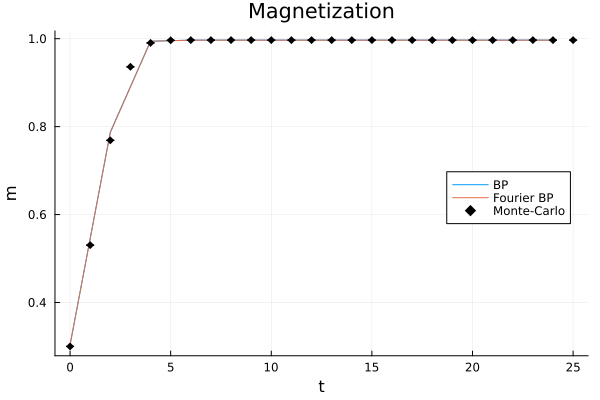

In [62]:
pl = plot(0:2:T, m[1:2:end], label="BP", xlabel="t", ylabel="m", title="Magnetization", legend=:right)
plot!(pl, 0:2:T, m_fourier[1:2:end], label="Fourier BP")
plot!(pl, 0:T, m_mc, yerr=σ_mc, c=:black, m=:diamond, st=:scatter, label="Monte-Carlo")